# Introduction to Blocks

Where Spaces describe structure Blocks describe function. They can represent how two spaces are related to each other or how a space is related to itself. Generally speaking, a block is any transformation that takes inputs typed by spaces and returns outputs typed by spaces. In this introduction to blocks we will show how to construct blocks by first identifying the spaces which are the domains and codomains, then providing logic to map from points from the domain onto points in the codomain.

In [1]:
from typing import List, Tuple, Callable
import numpy as np

In [2]:
particle = {'schema': {'location': np.ndarray[tuple[int, int], float], 'direction': np.ndarray[tuple[int, int], float]},
          'description': "A particle on a cartesian plane with a location and a direction."
          }

particle

{'schema': {'location': numpy.ndarray[tuple[int, int], float],
  'direction': numpy.ndarray[tuple[int, int], float]},
 'description': 'A particle on a cartesian plane with a location and a direction.'}

In [3]:
def particleSchemaCheck(point) -> bool:
    bit = True
    
    #check if the point is a dictionary
    if not isinstance(point, dict):
        print("point is not a dictionary")
        return False
    
    #check if the point has key 'location'
    if 'location' not in point:
        print("point does not have key 'location'")
        return False
    
    #check if the point has key 'direction'
    if 'direction' not in point:
        print("point does not have key 'direction'")
        return False
    
    #check if the value of 'location' is a numpy array
    if not isinstance(point['location'], np.ndarray):
        print("value of 'location' is not a numpy array")
        return False
    
    #check if the value of 'direction' is a numpy array
    if not isinstance(point['direction'], np.ndarray):
        print("value of 'direction' is not a numpy array")
        return False
    
    #check if the shape of 'location' is (2,)
    if point['location'].shape != (2,):
        print("shape of 'location' is not (2,)")
        return False
    
    #check if the shape of 'direction' is (2,)
    if point['direction'].shape != (2,):
        print("shape of 'direction' is not (2,)")
        return False
    
    return bit

particle['constraint'] = particleSchemaCheck

Now that we have a space representing a simple particle in a Cartesian Plane, lets create a block to describe its motion. Initially we know that a block describing the motion of a particle should take the current state of the particle in and return the new state of the particle, so we know that both its domain and its codomain must be `particle`.

In [4]:
motion_block = {'domain':particle, 'codomain':particle}
print(motion_block)

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11cb3ea20>}, 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11cb3ea20>}}


Now we need to equip the block with some logic -- let's suppose that we have a discrete time dynamical system with the following law of motion

$$ x^+ = x+ \dot x \frac{\Delta t + (1 - f)^{\Delta t}}{2}$$
$$ y^+ = y+ \dot y \frac{\Delta t + (1 - f)^{\Delta t}}{2}$$
$$ \dot x^+ = \dot x (1 - f)^{\Delta t} $$
$$ \dot y^+ = \dot y (1 - f)^{\Delta t} $$

here we use $(x,y)$ to denote `location` and $(\dot x, \dot y)$ to denote `direction`. We also introducted two parameters a coeficient of friction `f` and dicrete time periodn `\Delta t`.

In [5]:
paramSpace = {'schema': {'friction': float, 'dt': float}, 'constraint': lambda x: x['friction'] > 0 and x['friction']<1 and x['dt'] > 0 }

In [6]:
paramPoint = {'friction': 0.5, 'dt': 0.1}
print(paramPoint)
print(paramSpace['constraint'](paramPoint))

{'friction': 0.5, 'dt': 0.1}
True


In [7]:
motion_block['paramSpace'] = paramSpace
motion_block

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'paramSpace': {'schema': {'friction': float, 'dt': float},
  'constraint': <function __main__.<lambda>(x)>}}

In [8]:
def motion_func_creator(params: paramSpace) -> Callable[[particle], particle]:
    friction = params['friction']
    dt = params['dt']
    def motion_func(particle: particle) -> particle:
        
        #use the domain constraint to check the input
        assert motion_block['domain']['constraint'](particle)

        new_particle = {}
        new_particle['location'] = particle['location'] + particle['direction'] * ((dt + (1 - friction)**dt) / 2)
        new_particle['direction'] = particle['direction'] * ((1 - friction)**dt)

        #use the codomain constraint to check the output
        assert motion_block['codomain']['constraint'](new_particle)

        return new_particle
    return motion_func

In [9]:
motion_func = motion_func_creator(paramPoint)
motion_func

<function __main__.motion_func_creator.<locals>.motion_func(particle: {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11cb3ea20>}) -> {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11cb3ea20>}>

In [10]:
motion_block['logic'] = motion_func
motion_block

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'paramSpace': {'schema': {'friction': float, 'dt': float},
  'constraint': <function __main__.<lambda>(x)>},
 'logic': <function __main__.motion_func_creator.<locals>.motion_func(particle: {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleS

In [11]:
particlet0 = {'location': np.array([0.0, 0.0]), 'direction': np.array([1.0, 1.0])}
particlet0

{'location': array([0., 0.]), 'direction': array([1., 1.])}

In [12]:
particlet1 = motion_block['logic'](particlet0)
particlet1

{'location': array([0.5165165, 0.5165165]),
 'direction': array([0.93303299, 0.93303299])}

In [13]:
#create a list of particles by applying the motion function to the previous particle
def motion_sequence(particle: particle, n: int, motion_func: Callable[[particle], particle]) -> List[particle]:
    particles = [particle]
    for i in range(n):
        particles.append(motion_func(particles[-1]))
    return particles

trajectory= motion_sequence(particlet0, 25, motion_func)
trajectory

[{'location': array([0., 0.]), 'direction': array([1., 1.])},
 {'location': array([0.5165165, 0.5165165]),
  'direction': array([0.93303299, 0.93303299])},
 {'location': array([0.99844343, 0.99844343]),
  'direction': array([0.87055056, 0.87055056])},
 {'location': array([1.44809715, 1.44809715]),
  'direction': array([0.8122524, 0.8122524])},
 {'location': array([1.86763891, 1.86763891]),
  'direction': array([0.75785828, 0.75785828])},
 {'location': array([2.25908522, 2.25908522]),
  'direction': array([0.70710678, 0.70710678])},
 {'location': array([2.62431754, 2.62431754]),
  'direction': array([0.65975396, 0.65975396])},
 {'location': array([2.96509134, 2.96509134]),
  'direction': array([0.61557221, 0.61557221])},
 {'location': array([3.28304454, 3.28304454]),
  'direction': array([0.57434918, 0.57434918])},
 {'location': array([3.57970536, 3.57970536]),
  'direction': array([0.53588673, 0.53588673])},
 {'location': array([3.8564997, 3.8564997]), 'direction': array([0.5, 0.5])},


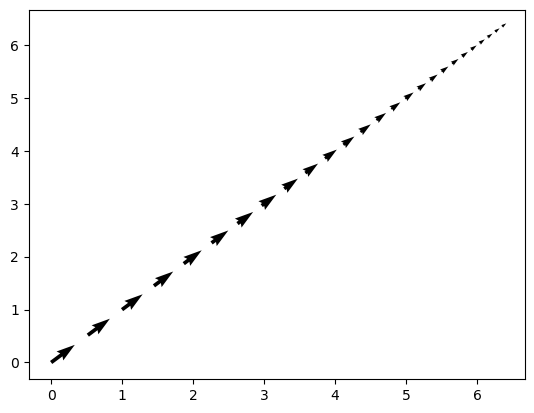

In [14]:
#plot the trajectory
import matplotlib.pyplot as plt
x = [p['location'][0] for p in trajectory]
y = [p['location'][1] for p in trajectory]
u = [p['direction'][0] for p in trajectory]
v = [p['direction'][1] for p in trajectory]
plt.quiver(x, y, u, v, scale=3, scale_units='xy', angles='xy')
plt.show()

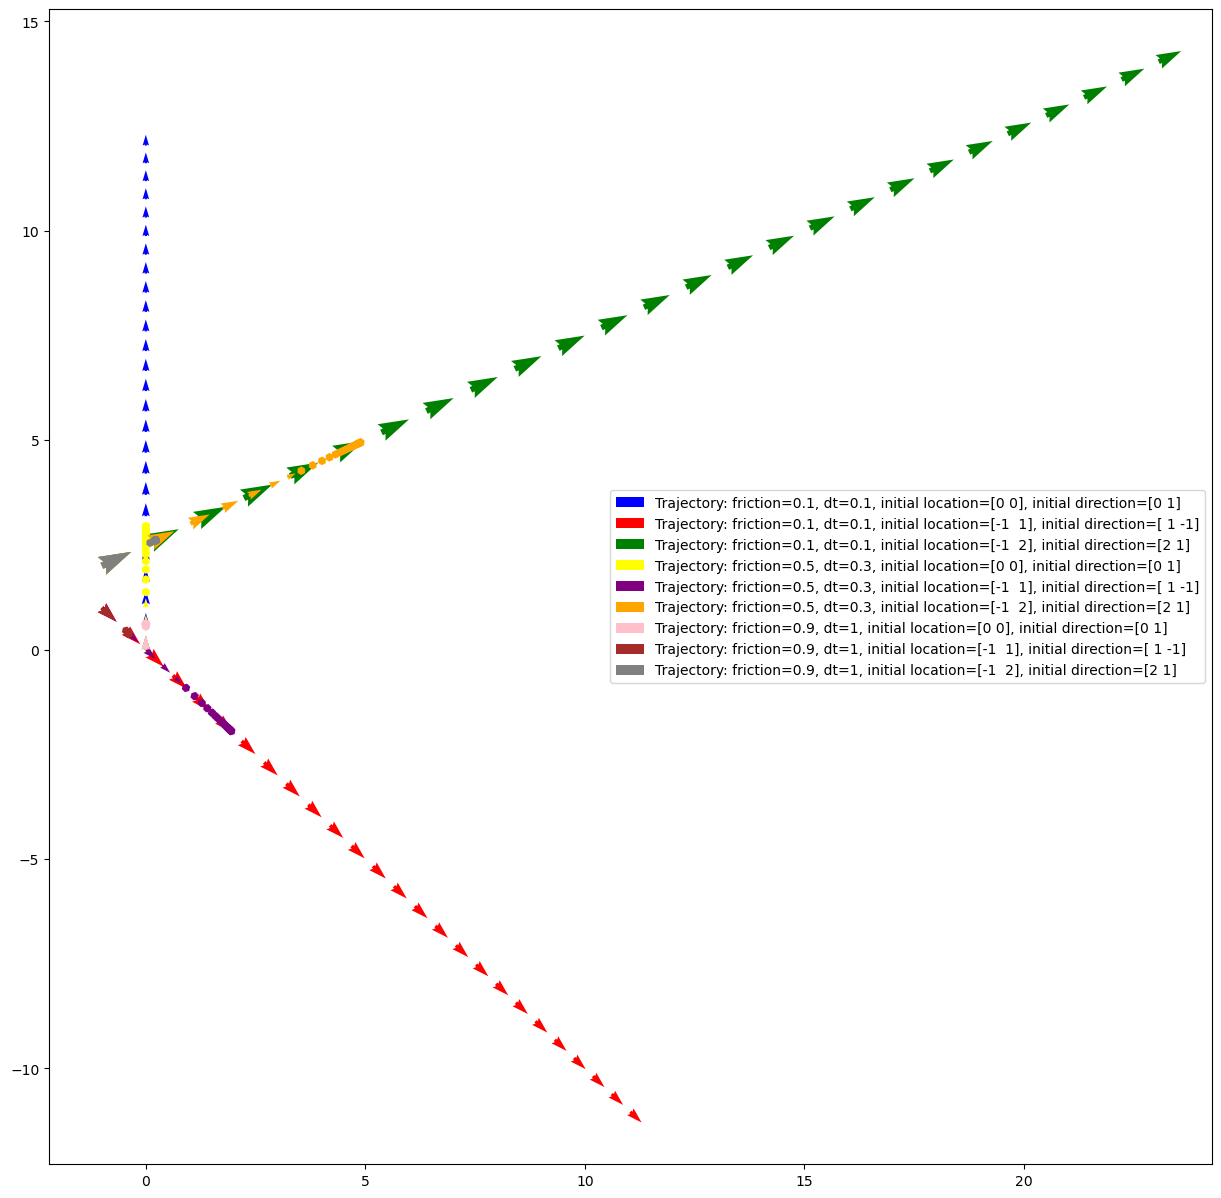

In [22]:
# create a loop we change the parameters and the initial conditions and replot the trajectory
paramPoints = [{'friction': 0.1, 'dt': 0.1}, {'friction': 0.5, 'dt': 0.3}, {'friction': 0.9, 'dt': 1}]
particlet0s = [{'location': np.array([0, 0]), 'direction': np.array([0, 1])}, {'location': np.array([-1, 1]), 'direction': np.array([1, -1])}, {'location': np.array([-1, 2]), 'direction': np.array([2, 1])}]

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'grey']
plt.figure(figsize=(15, 15))
for i, paramPoint in enumerate(paramPoints):
    for j, particlet0 in enumerate(particlet0s):
        motion_func = motion_func_creator(paramPoint)
        trajectory = motion_sequence(particlet0, 25, motion_func)
        x = [p['location'][0] for p in trajectory]
        y = [p['location'][1] for p in trajectory]
        u = [p['direction'][0] for p in trajectory]
        v = [p['direction'][1] for p in trajectory]

        
        plt.quiver(x, y, u, v, scale=3, scale_units='xy', angles='xy', color=colors[(i*len(particlet0s)+j)%len(colors)], label=f"Trajectory: friction={paramPoint['friction']}, dt={paramPoint['dt']}, initial location={particlet0['location']}, initial direction={particlet0['direction']}")
plt.legend()

plt.show()

By looping over the block with different parameters and initial conditions we can clearly see the effects of the changes to the parameters. Larger `dt` leads to dynamics playing out faster, and larger `friction` leads to slowing down faster.